In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

C:\Users\nessl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES",'col',['K16','L16','M16'])

#correct = correct/2100

#correct['Time'] = correct['Time']*2100

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1nM_target',
                   "['K10', 'L10', 'M10']": '0.1nM_target',
                     "['K11', 'L11', 'M11']":'0.01nM_target' ,
                     "['K12', 'L12', 'M12']": '1pM_target',
                    "['K13', 'L13', 'M13']": '0.1pM_target',
                      "['K14', 'L14', 'M14']":'0.01pM_target' ,
                     "['K15', 'L15', 'M15']": '0.1fM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1nM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1nM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01nM_target_std',
                   6: '1µM_FITC_std',
                     7:'1pM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1pM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01pM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1fM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

,10µM_FITC,1nM_target,5µM_FITC,0.1nM_target,2µM_FITC,0.01nM_target,1µM_FITC,1pM_target,0.1µM_FITC,0.1pM_target,...,1µM_FITC_std,1pM_target_std,0.1µM_FITC_std,0.1pM_target_std,0.01µM_FITC_std,0.01pM_target_std,1nM_FITC_std,0.1fM_target_std,NC_FITC_std,NC_target_std
0,9.697937,0.055873,4.803333,0.000000,1.954603,0.009841,1.135397,0.0,0.391905,0.0,...,0.136073,0.244756,0.082644,0.091951,0.058089,0.056878,0.054902,0.007866,0.014142,0.011208
1,8.678571,0.388095,4.078571,0.000000,1.334603,0.000000,0.628889,0.0,0.000000,0.0,...,0.133369,0.726438,0.038502,0.847473,0.063122,0.623463,0.079329,0.866017,0.084873,0.758101
2,12.689206,1.199524,6.717937,0.078254,2.983651,0.000000,1.790794,0.0,1.228095,0.0,...,0.394305,0.336887,0.207361,0.194752,0.291521,0.172988,0.148309,0.156005,0.152101,0.185042
3,12.426984,2.635714,6.500952,0.618413,2.926667,0.000000,2.038095,0.0,1.305397,0.0,...,0.161015,0.335035,0.191609,0.177314,0.119023,0.159265,0.179541,0.169277,0.108229,0.262830
4,12.210159,3.302222,6.296508,1.371587,2.918889,0.000000,2.135079,0.0,1.412381,0.0,...,0.173781,0.338014,0.228196,0.181659,0.113460,0.053356,0.216622,0.189353,0.135465,0.251958


In [50]:
def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,180,37)
    
    t = np.linspace(0,500,500)
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        err.append((obs[i]-m.tolist()[2][i])**2)  
        
    
    erro = np.sum(err)

    return erro

## Try by hand

In [13]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.6
Tc0 = 0.
Tu0 = 0.001

# Parameters (in /min)
k1 = 0.1
k3 = 600
k4 = 0.3


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

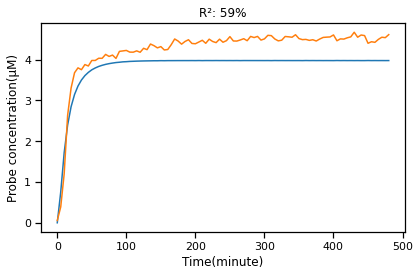

In [6]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])


sns.set_context('notebook')
sns.set_palette("tab10")

plt.plot(times,m[2])
plt.plot(times,correct[correct.columns[1]])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r*100))+'%')
plt.tight_layout()
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()

## With minimization

In [7]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.6
Tc0 = 0.
Tu0 = 0.001

# Parameters (in /min)
k1 = 0.1
k3 = 800
k4 = 0.3


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

bnds = [(0.001,2),(100,1000),(0.003,3)]
res = optimize.minimize(error, param, args=(list(correct[correct.columns[1]])),method='Nelder-Mead',bounds=bnds)#

In [8]:
res.x

array([5.31530328e-02, 8.46450220e+02, 2.45801441e-01])

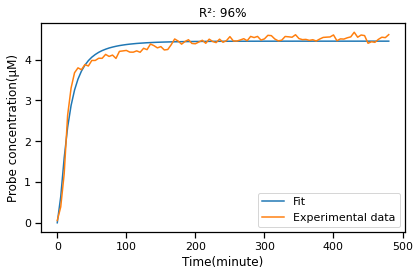

In [9]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.plot(times,correct[correct.columns[1]],label="Experimental data")
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r*100))+'%')
plt.tight_layout()
plt.legend()
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
plt.show()

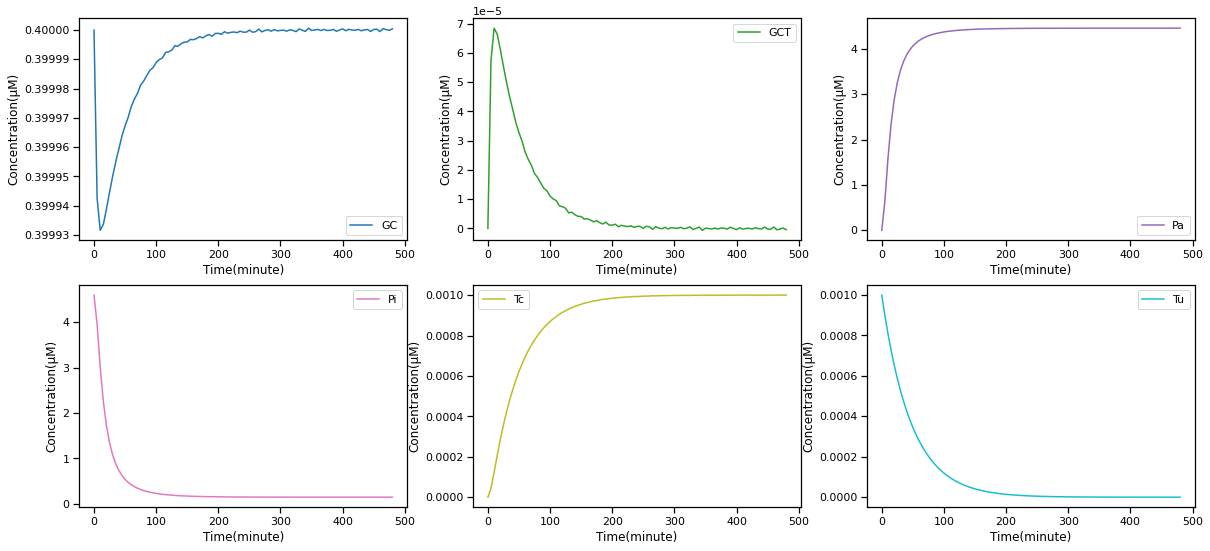

In [10]:
fig,ax = plt.subplots(2,3)
fig.set_size_inches(20,9)

def get_cmap(n, name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(6)

counter=0
name = ["GC",'GCT',"Pa","Pi","Tc","Tu"]
for r in range(2):
    for c in range(3):
        ax[r,c].plot(times,m[counter],label=name[counter],c=cmap(counter))
        ax[r,c].set_xlabel('Time(minute)')
        ax[r,c].set_ylabel('Concentration(µM)')
        ax[r,c].legend()
        ax[r,c].ticklabel_format(useOffset=False)
        counter += 1
    
#plt.savefig("../images/SHERLOCK/modeling/all_species.png",dpi=300)
plt.show()

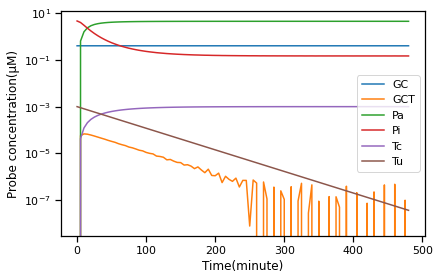

In [12]:
plt.plot(times,m.T)
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.tight_layout()
plt.legend(["GC",'GCT',"Pa","Pi","Tc","Tu"],loc='right')
plt.yscale('log')
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
plt.show()

## Test multiple gain

In [4]:
correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,50,"YES",'col',['K16','L16','M16'])

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1nM_target',
                   "['K10', 'L10', 'M10']": '0.1nM_target',
                     "['K11', 'L11', 'M11']":'0.01nM_target' ,
                     "['K12', 'L12', 'M12']": '1pM_target',
                    "['K13', 'L13', 'M13']": '0.1pM_target',
                      "['K14', 'L14', 'M14']":'0.01pM_target' ,
                     "['K15', 'L15', 'M15']": '0.1fM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1nM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1nM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01nM_target_std',
                   6: '1µM_FITC_std',
                     7:'1pM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1pM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01pM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1fM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

,10µM_FITC,1nM_target,5µM_FITC,0.1nM_target,2µM_FITC,0.01nM_target,1µM_FITC,1pM_target,0.1µM_FITC,0.1pM_target,...,1µM_FITC_std,1pM_target_std,0.1µM_FITC_std,0.1pM_target_std,0.01µM_FITC_std,0.01pM_target_std,1nM_FITC_std,0.1fM_target_std,NC_FITC_std,NC_target_std
0,9.593190,0.035842,4.743728,0.000000,1.933692,0.0,1.182796,0.0,0.333333,0.0,...,0.129802,0.234856,0.058949,0.115338,0.054887,0.070007,0.057292,0.009138,0.065895,0.018276
1,8.788530,0.630824,4.044803,0.000000,1.403226,0.0,0.639785,0.0,0.000000,0.0,...,0.161827,0.717701,0.063765,0.824264,0.107198,0.615262,0.075311,0.786116,0.181332,0.765382
2,12.804659,1.369176,6.817204,0.071685,3.057348,0.0,1.888889,0.0,1.216846,0.0,...,0.387901,0.344375,0.173623,0.242949,0.046938,0.212182,0.144951,0.161350,0.112290,0.229461
3,12.281362,2.682796,6.485663,0.682796,3.021505,0.0,1.976703,0.0,1.277778,0.0,...,0.148670,0.339813,0.190892,0.191899,0.062442,0.169807,0.190959,0.218888,0.121256,0.225778
4,12.103943,3.372760,6.390681,1.575269,3.007168,0.0,2.215054,0.0,1.421147,0.0,...,0.194360,0.365987,0.287856,0.218005,0.133510,0.134612,0.169561,0.120699,0.130443,0.147716


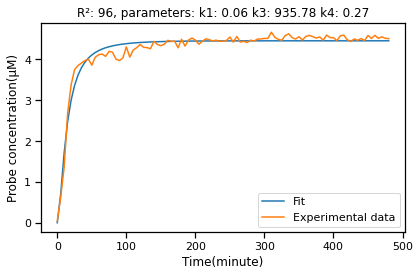

In [14]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.6
Tc0 = 0.
Tu0 = 0.001

# Parameters (in /min)
k1 = 0.1
k3 = 800
k4 = 0.3


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

#'''
bnds = [(0.001,2),(100,1000),(0.003,3)]
res = optimize.minimize(error, param, args=(list(correct[correct.columns[1]])),method='Nelder-Mead',bounds=bnds)#

times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])
#'''
sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.plot(times,correct[correct.columns[1]],label="Experimental data")
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title(f'R²: {(round(r*100))}, parameters: k1: {round(res.x[0],2)} k3: {round(res.x[1],2)} k4: {round(res.x[2],3)}')
plt.tight_layout()
plt.legend()
#plt.savefig("../images/SHERLOCK/modeling/better_model_50.png",dpi=300)
plt.show()

### Make a function that computes everything automatically


In [52]:
def catalytic(exp,g,c):
    '''
    Inputs:
    exp: the experimment wanted
    g: gain of the machine
    c: the column that you want to fit (i.e) the data fitted
    
    '''
    correct = px.mainf(exp[0],g,exp[1],exp[2],exp[3])

    #Initial conditions (concentrations in microM)
    GC0 = 0.4 
    GCT0 = 0.
    Pa0 = 0.
    Pi0 = 4.6
    Tc0 = 0.
    Tu0 = 0.001

    # Parameters (in /min)
    k1 = 0.1
    k3 = 800
    k4 = 0.3

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
    param  = [k1,k3,k4]

    bnds = [(0.001,2),(100,1000),(0.003,3)]
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[c]])),method='Nelder-Mead',bounds=bnds)#

    times = np.linspace(0,180,37)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    r = r2_score(correct[correct.columns[c]],m[2])
    
    return [res.x,r]

In [45]:
print(f'The catalytic constant is {catalytic(70,1)[0][1]} min-1')
print(f'The catalytic constant is {catalytic(70,3)[0][1]} min-1')
print(f'The catalytic constant is {catalytic(70,5)[0][1]} min-1')

#for i in [75,70,50]:
 #   print(f'The catalytic constant is {catalytic(i)[0][1]} $min^{{-1}}$')

The catalytic constant is 846.4502197835902 min-1
The catalytic constant is 1000.0 min-1
The catalytic constant is 100.0 min-1


In [40]:
exp = ['../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx',"YES",'col',['K16','L16','M16']]
cat = []
for i in [1,3,5]:
    cat.append(catalytic(exp,70,i)[0][1])

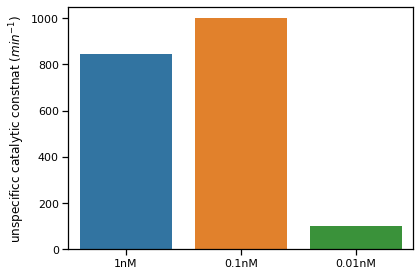

In [37]:
sns.set_palette("tab10")
sns.set_context("notebook")
sns.barplot([1,2,3],cat)
plt.xticks([0,1,2],["1nM","0.1nM","0.01nM"])
plt.ylabel('unspecificc catalytic constnat ($min^{-1}$)')
plt.tight_layout()
#plt.savefig("../images/SHERLOCK/modeling/cat_const_target.png",dpi=300)
plt.show()

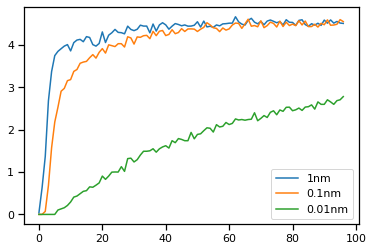

In [53]:
plt.rcParams['text.usetex'] = False

correct[correct.columns[1]].plot(label='1nm')
correct[correct.columns[3]].plot(label='0.1nm')
correct[correct.columns[5]].plot(label='0.01nm')
plt.legend()
plt.show()

In [58]:
exp = ['../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_3_v2.xlsx',"YES",'col',['J6','K6','L6']]

cat = []
for i in range(3):
    cat.append(catalytic(exp,75,i)[0][1])

In [57]:
cat

[846.4502197835902, 1000.0, 100.0, 1000.0, 1000.0, 106.05681106058677, 100.0]

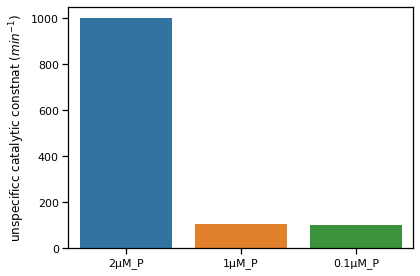

In [67]:
sns.set_palette("tab10")
sns.set_context("notebook")
sns.barplot([1,2,3],cat)
plt.xticks([0,1,2],['2µM_P','1µM_P','0.1µM_P'])
plt.ylabel('unspecificc catalytic constnat ($min^{-1}$)')
plt.tight_layout()
plt.savefig("../images/SHERLOCK/modeling/cat_probe_dilution.png",dpi=300)
plt.show()

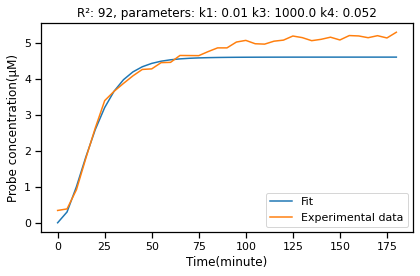

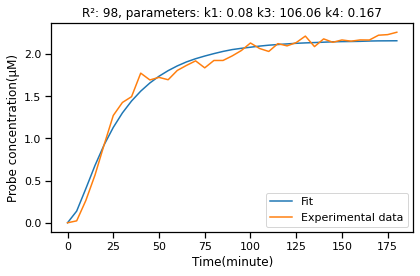

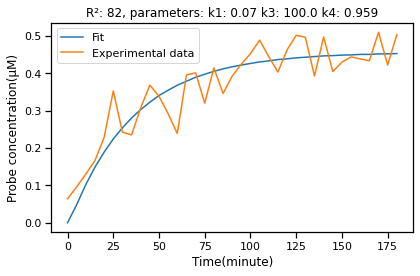

In [69]:
probe = px.mainf('../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_3_v2.xlsx',
               75,"YES",'col',['J6','K6','L6'])

#i = 0

for i in range(3):
    #Initial conditions (concentrations in microM)
    GC0 = 0.4 
    GCT0 = 0.
    Pa0 = 0.
    Pi0 = 4.6
    Tc0 = 0.
    Tu0 = 0.001

    # Parameters (in /min)
    k1 = 0.1
    k3 = 800
    k4 = 0.3

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
    param  = [k1,k3,k4]

    bnds = [(0.001,2),(100,1000),(0.003,3)]
    res = optimize.minimize(error, param, args=(list(probe[probe.columns[i]])),method='Nelder-Mead',bounds=bnds)#

    times = np.linspace(0,180,37)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    r = r2_score(probe[probe.columns[i]],m[2])

    sns.set_context('notebook')
    #sns.set_palette("tab10")

    plt.plot(times,m[2],label="Fit")
    plt.plot(times,probe[probe.columns[i]],label="Experimental data")
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.title(f'R²: {(round(r*100))}, parameters: k1: {round(res.x[0],2)} k3: {round(res.x[1],2)} k4: {round(res.x[2],3)}')
    plt.tight_layout()
    plt.legend()
    #plt.savefig("../images/SHERLOCK/modeling/better_model_2µM.png",dpi=300)
    plt.show()